# Posterior inference on a birth-death model

In [1]:
from collections import defaultdict

import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import jit
from jax.config import config
from mcmc_diagnostics import estimate_ess
from scipy.stats import gamma, lognorm, norm

from gcdyn import models, mutators, poisson, utils
from gcdyn.mcmc import Parameter, mh_chain

config.update("jax_enable_x64", True)

## Set up truth

In [2]:
STATE_SPACE = (2, 4, 6, 8)
INITIAL_STATE = 2
PRESENT_TIME = 1
NUM_TREES = 15

TRUE_PARAMETERS = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 3.0, 1.0),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(2),
    "mutator": mutators.DiscreteMutator(
        state_space=STATE_SPACE,
        transition_matrix=np.array(
            [[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]]
        )
        / 3,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

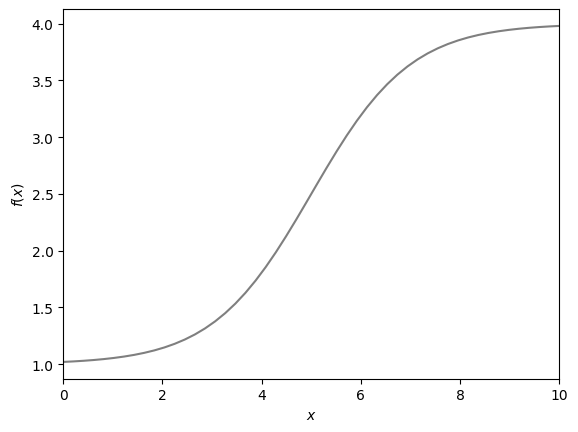

In [3]:
utils.plot_responses(TRUE_PARAMETERS["birth_response"], x_range=(0, 10))

## Sample trees

In [20]:
trees = utils.sample_trees(
    n=NUM_TREES,
    t=PRESENT_TIME,
    init_x=INITIAL_STATE,
    **TRUE_PARAMETERS,
    seed=10,
)

  0%|          | 0/15 [00:00<?, ?it/s]

Notice: obtained error 'cannot prune because no leaves were sampled' 14 times.
Average of 20.8 nodes per tree, and average of 7.2 leaves per tree, over 15 trees.
Type 2 exists in 65 nodes
Type 4 exists in 58 nodes
Type 6 exists in 81 nodes
Type 8 exists in 108 nodes


## Configure priors and proposals

In [9]:
XSCALE_PRIOR_SHAPE = 2
XSCALE_PRIOR_SCALE = 1
XSHIFT_PRIOR_MEAN = 5
XSHIFT_PRIOR_SD = 1
YSCALE_PRIOR_SHAPE = 2
YSCALE_PRIOR_SCALE = 1
YSHIFT_PRIOR_SHAPE = 1
YSHIFT_PRIOR_SCALE = 1
DR_PRIOR_MEAN = 0
DR_PRIOR_SD = 0.3

XSCALE_PROPOSAL_SD = 3
XSHIFT_PROPOSAL_SD = 2
YSCALE_PROPOSAL_SD = 1
YSHIFT_PROPOSAL_SD = 1
DR_PROPOSAL_SD = 0.5

MCMC_SEED = 10
NUM_MCMC_SAMPLES = 5000

MCMC_PARAMETERS = dict(
    xscale=Parameter(
        prior_log_density=gamma(a=XSCALE_PRIOR_SHAPE, scale=XSCALE_PRIOR_SCALE).logpdf,
        prior_generator=lambda n, rng: gamma(
            a=XSCALE_PRIOR_SHAPE, scale=XSCALE_PRIOR_SCALE
        ).rvs(n, random_state=rng),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=XSCALE_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c, rng: lognorm(scale=c, s=XSCALE_PROPOSAL_SD).rvs(
            1, random_state=rng
        ),
    ),
    xshift=Parameter(
        prior_log_density=norm(loc=XSHIFT_PRIOR_MEAN, scale=XSHIFT_PRIOR_SD).logpdf,
        prior_generator=lambda n, rng: norm(
            loc=XSHIFT_PRIOR_MEAN, scale=XSHIFT_PRIOR_SD
        ).rvs(n, random_state=rng),
        proposal_log_density=lambda p, c: norm(loc=c, scale=XSHIFT_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c, rng: norm(loc=c, scale=XSHIFT_PROPOSAL_SD).rvs(
            1, random_state=rng
        ),
    ),
    yscale=Parameter(
        prior_log_density=gamma(a=YSCALE_PRIOR_SHAPE, scale=YSCALE_PRIOR_SCALE).logpdf,
        prior_generator=lambda n, rng: gamma(
            a=YSCALE_PRIOR_SHAPE, scale=YSCALE_PRIOR_SCALE
        ).rvs(n, random_state=rng),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=YSCALE_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c, rng: lognorm(scale=c, s=YSCALE_PROPOSAL_SD).rvs(
            1, random_state=rng
        ),
    ),
    yshift=Parameter(
        prior_log_density=gamma(a=YSHIFT_PRIOR_SHAPE, scale=YSHIFT_PRIOR_SCALE).logpdf,
        prior_generator=lambda n, rng: gamma(
            a=YSHIFT_PRIOR_SHAPE, scale=YSHIFT_PRIOR_SCALE
        ).rvs(n, random_state=rng),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=YSHIFT_PROPOSAL_SD).logpdf(
            p
        ),
        proposal_generator=lambda c, rng: lognorm(scale=c, s=YSHIFT_PROPOSAL_SD).rvs(
            1, random_state=rng
        ),
    ),
    death_rate=Parameter(
        prior_log_density=lognorm(scale=np.exp(DR_PRIOR_MEAN), s=DR_PRIOR_SD).logpdf,
        prior_generator=lambda n, rng: lognorm(
            scale=np.exp(DR_PRIOR_MEAN), s=DR_PRIOR_SD
        ).rvs(n, random_state=rng),
        proposal_log_density=lambda p, c: lognorm(scale=c, s=DR_PROPOSAL_SD).logpdf(p),
        proposal_generator=lambda c, rng: lognorm(scale=c, s=DR_PROPOSAL_SD).rvs(
            1, random_state=rng
        ),
    ),
)

## Configure likelihood

In [10]:
@jit
def log_likelihood(death_rate, **birth_params):
    return models.stadler_full_log_likelihood(
        trees=trees,
        birth_response=poisson.SigmoidResponse(**birth_params),
        death_response=poisson.ConstantResponse(death_rate),
        mutation_response=TRUE_PARAMETERS["mutation_response"],
        mutator=TRUE_PARAMETERS["mutator"],
        extant_sampling_probability=TRUE_PARAMETERS["extant_sampling_probability"],
        extinct_sampling_probability=TRUE_PARAMETERS["extinct_sampling_probability"],
        present_time=PRESENT_TIME,
    )

## Run MCMC

In [11]:
posterior_samples, stats = mh_chain(
    length=1000, parameters=MCMC_PARAMETERS, log_likelihood=log_likelihood, seed=10
)

Running MH chain...


  0%|          | 0/1000 [00:00<?, ?it/s]

## Traceplots

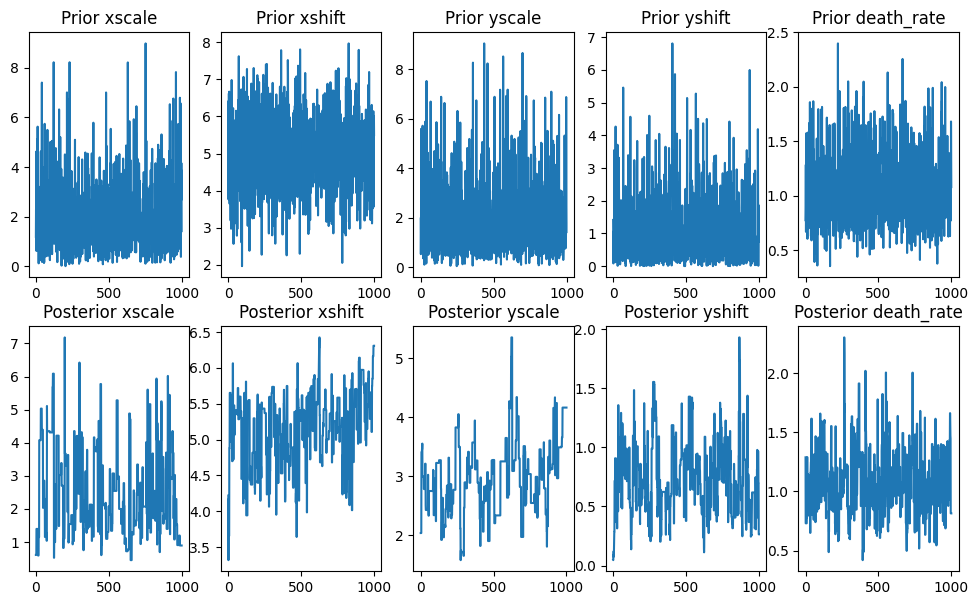

In [12]:
prior_samples = {
    name: param.prior_generator(1000, None) for name, param in MCMC_PARAMETERS.items()
}

fig, axes = plt.subplots(2, len(posterior_samples))
fig.set_figwidth(12)
fig.set_figheight(7)

for i, param in enumerate(posterior_samples):
    sns.lineplot(prior_samples[param], ax=axes[0, i])
    axes[0, i].set_title(f"Prior {param}")
    sns.lineplot(posterior_samples[param], ax=axes[1, i])
    axes[1, i].set_title(f"Posterior {param}")

plt.show()

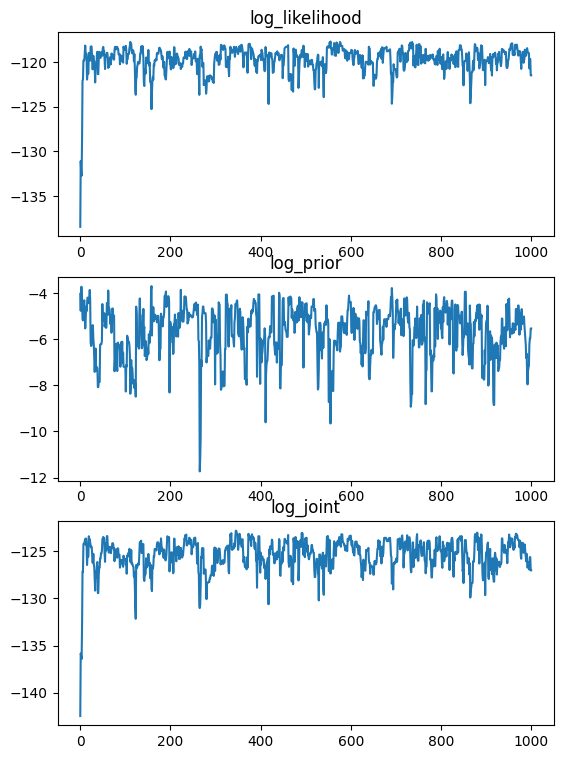

In [13]:
fig, axes = plt.subplots(len(stats))
fig.set_figheight(9)

for ax, stat in zip(axes, stats):
    sns.lineplot(stats[stat], ax=ax)
    ax.set_title(stat)

plt.show()

## Summaries

In [14]:
summary = defaultdict(list)

for param in sorted(posterior_samples.keys()):
    summary["Parameter"].append(param)
    summary["Total samples"].append(len(posterior_samples[param]))

    try:
        summary["ESS"].append(estimate_ess(posterior_samples[param]).item())
    except:
        # A parameter is probably fixed, so the posterior is a point mass
        summary["ESS"].append(np.nan)

    summary["Acceptance ratio"].append(
        np.mean(posterior_samples[param][:-1] != posterior_samples[param][1:])
    )
    summary["Prior mean"].append(prior_samples[param].mean())
    summary["Posterior mean"].append(posterior_samples[param].mean())

pd.DataFrame(summary).round(2).set_index("Parameter")

,Total samples,ESS,Acceptance ratio,Prior mean,Posterior mean
Parameter,,,,,
death_rate,1001,197.85,0.508,1.06,1.09
xscale,1001,98.93,0.20600002,1.96,2.54
xshift,1001,130.38,0.26500002,5.02,5.17
yscale,1001,34.71,0.155,2.01,2.99
yshift,1001,84.40,0.363,1.04,0.75


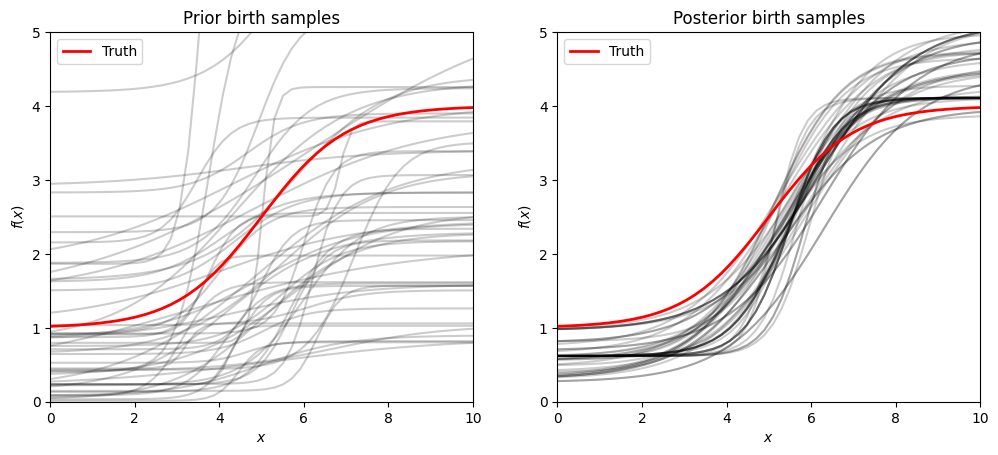

In [15]:
x_array = np.linspace(0, 10)

fig, axes = plt.subplots(1, 2)

for samples, ax in zip((prior_samples, posterior_samples), axes):
    birth_responses = []

    for i in range(len(samples["xscale"]) - 50, len(samples["xscale"])):
        response = poisson.SigmoidResponse(
            xscale=samples["xscale"][i].item(),
            xshift=samples["xshift"][i].item(),
            yscale=samples["yscale"][i].item(),
            yshift=samples["yshift"][i].item(),
        )

        birth_responses.append(response)

    for response in birth_responses:
        ax.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)

    ax.plot(
        x_array,
        TRUE_PARAMETERS["birth_response"].λ_phenotype(x_array),
        label="Truth",
        linewidth=2,
        color="red",
    )

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.legend()

axes[0].set_title("Prior birth samples")
axes[1].set_title("Posterior birth samples")
fig.set_figwidth(12)
plt.show()

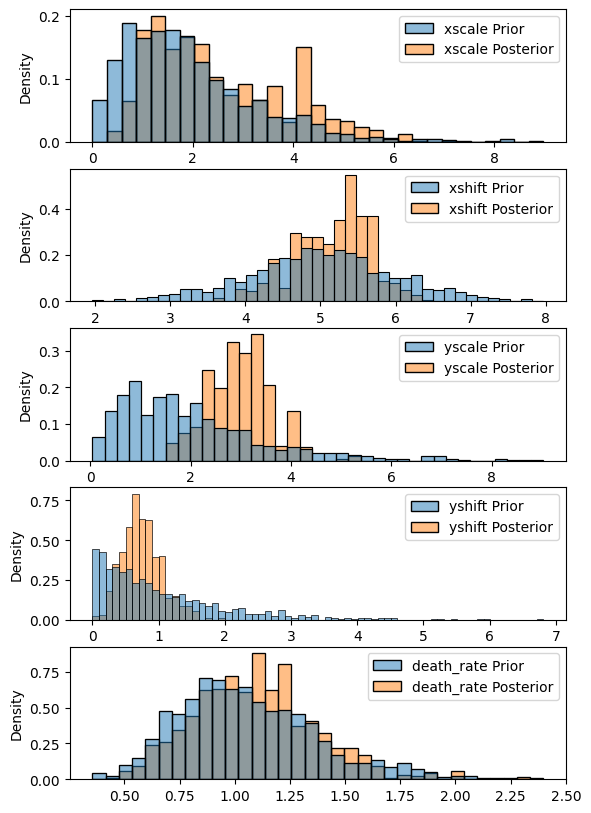

In [16]:
fig, axes = plt.subplots(len(posterior_samples), 1)
fig.set_figheight(10)

for ax, param in zip(axes, posterior_samples):
    s = {
        f"{param} Prior": prior_samples[param],
        f"{param} Posterior": posterior_samples[param],
    }

    sns.histplot(s, ax=ax, stat="density")